In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [ ]:
!mkdir -p datasets/

In [ ]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz datasets/

download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz
download: s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz to datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz


In [ ]:
!mkdir 3band 8band geojson

In [ ]:
!rm -rf datasets/3band
!rm -rf datasets/8band
!rm -rf datasets/geojson

In [ ]:
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz -C datasets/

In [3]:
import os
from os.path import join

In [ ]:
image_3b = "datasets/3band"
image_8b = "datasets/8band"
geojson = "datasets/geojson"
print(len([name for name in os.listdir(image_3b)]), "3b images")
print(len([name for name in os.listdir(image_8b)]), "8b images")
print(len([name for name in os.listdir(geojson)]), "geojson labels")

6940 3b images
6940 8b images
6940 geojson labels


In [ ]:
!pip install rasterio

In [81]:
import importlib
import models.CreateDataLoaders
import models.CreateDataset
import preprocess.SplitDataset
importlib.reload(models.CreateDataLoaders)
importlib.reload(models.CreateDataset)
# importlib.reload(preprocess.SplitDataset)

<module 'models.CreateDataset' from '/content/models/CreateDataset.py'>

In [49]:
from preprocess.SplitDataset import SplitDataset

target_dir = "/content/train/"
os.makedirs(target_dir, exist_ok=True)
SplitDataset(
    data_dir="/content/datasets",
    target_dir=target_dir
)


[INFO] Copying 5899 files to 'train/'...


Copying to train: 100%|██████████| 5899/5899 [01:18<00:00, 75.04file/s] 


[✓] train set created with 5899 image-mask pairs.

[INFO] Copying 1041 files to 'val/'...


Copying to val: 100%|██████████| 1041/1041 [00:07<00:00, 136.65file/s]

[✓] val set created with 1041 image-mask pairs.
[Done] Dataset split into train/val/test folders under: /content/train/


In [53]:
from preprocess.CreateMaskRasterio import convert_geojsons_to_masks
folders = ["train", "val"]

for folder in folders:
  source_dir = os.path.join(target_dir, folder, "3band")
  geojson_dir = os.path.join(target_dir, folder, "geojson")
  mask_dir = os.path.join(target_dir, folder, "mask")
  convert_geojsons_to_masks(geojson_dir, source_dir, mask_dir)

Creating masks: 100%|██████████| 1041/1041 [00:13<00:00, 75.49it/s] 


In [67]:
folders = ["train", "val"]
subfolders = ["3band", "8band", "geojson", "mask"]

for folder in folders:
    for subfolder in subfolders:
        folder_path = os.path.join(target_dir, folder, subfolder)
        print(len([name for name in os.listdir(folder_path)]), folder + "/" + subfolder)

5899 train/3band
5899 train/8band
5899 train/geojson
5899 train/mask
1041 val/3band
1041 val/8band
1041 val/geojson
1041 val/mask


In [82]:
from models.CreateDataLoaders import CreateDataLoaders
train_loader, val_loader = CreateDataLoaders(target_dir, batch_size=32, num_workers=4)
print(train_loader)
print(val_loader)

Found 5899 valid image-mask pairs
Found 1041 valid image-mask pairs


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [9]:
# Initialize model
from models.unet.model import UNet
model = UNet(num_classes=1, in_channels=3)  # Adjust in_channels based on your .tiff files
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model = model.to(device)

Using device:  cpu


/content/models/unet/model.py:211: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/models/unet/model.py:212: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


In [10]:
from DiceBCELoss import DiceBCELoss
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [11]:
start_epoch = 0
checkpoint_path = "checkpoint.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from next epoch
    print(f"[✓] Loaded checkpoint from epoch {start_epoch}")
else:
    print("[INFO] No checkpoint found. Training from scratch.")

[✓] Loaded checkpoint from epoch 100


In [ ]:
from tqdm import tqdm

# Trainig Loop
num_epochs = 100
for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.sigmoid(outputs) > 0.5
        acc = (pred == masks).float().mean()

        train_loss += loss.item()
        train_acc += acc.item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": acc.item()
        })

    # Validation phase
    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate Dice coefficient
            pred = torch.sigmoid(outputs) > 0.5
            dice_score += (2 * (pred * masks).sum()) / ((pred + masks).sum() + 1e-8)

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {val_loss/len(val_loader):.4f}, Dice: {dice_score/len(val_loader):.4f}')

    # Update learning rate based on validation losp
    scheduler.step(val_loss)

Epoch 1/100:   0%|          | 0/185 [00:00<?, ?it/s]

In [ ]:
# Save checkpoint after each epoch
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "train_loss": avg_train_loss,
    "val_loss": val_loss / len(val_loader),
    "dice_score": dice_score / len(val_loader)
}, checkpoint_path)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'building_segmentation_model.pth')

In [ ]:
# Clean up
del model, train_loader, val_loader, outputs, loss
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()

302

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Test


In [12]:
from models.unet.model import UNet
import torch

# Create the model with the same config as during training
model = UNet(num_classes=1, in_channels=3, depth=5, start_filts=64)

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=device)
  model.load_state_dict(checkpoint["model_state_dict"])
else:
  model.load_state_dict(torch.load('building_segmentation_model.pth', map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

/content/models/unet/model.py:211: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/content/models/unet/model.py:212: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 

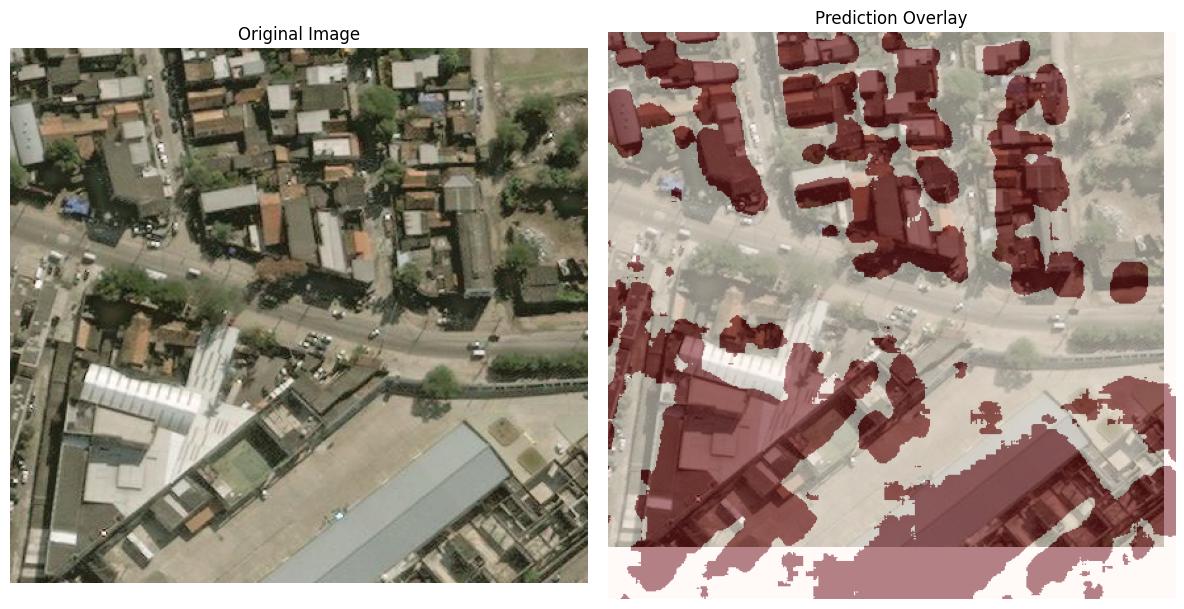

In [14]:
from utils.Utilities import predict
import utils.Visualize as vs

image_path = "/content/datasets/test/3band/3band_AOI_2_RIO_img1210.tif"
prediction = predict(model, image_path)

vs.visualizeOriginalWithMask(image_path, prediction)

In [ ]:
from google.colab import files
files.download(checkpoint_path)
files.download("building_segmentation_model.pth")